# FMCG Demand Forecasting Analysis

A practical approach to forecasting FMCG demand using statistical and ML methods.


In [5]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)


## 1. Data Loading & Exploration


In [59]:
df = pd.read_excel('sample.xlsx')
print(f'Dataset: {len(df)} rows x {len(df.columns)} columns')
df.head()


Dataset: 9033 rows x 8 columns


,Key,Area Code,Product Code,Date,Sales_Volume,Category,State,Remarks
0,HA29-AGNA1,HA29,AGNA1,01-05-2022,-5544.563,NaN,Maharashtra,?
1,HA06-LGMP8,HA06,LGMP8,01 Sep 2021,1822.883,Hi,Odisha,OK
2,HA42-AGNA3,HA42,AGNA3,2020.01.01,2926.559,PERSONAL WASH,Uttar Pradesh,Check
3,HA63-CEPR4,HA63,CEPR4,2021/06/01,97.332,fabric care,Rajasthan,NaN
4,HA38-AGNSA,HA38,AGNSA,2018/05/01,2217.451,Personal Wash,Madhya Pradesh,Check


### Data Quality Check


In [60]:
pd.DataFrame({
    'Column': df.columns,
    'Type': df.dtypes,
    'Nulls': df.isnull().sum(),
    'Null_%': (df.isnull().sum() / len(df) * 100).round(1),
    'Unique': [df[col].nunique() for col in df.columns]
})


,Column,Type,Nulls,Null_%,Unique
Key,Key,object,0,0.0,99
Area Code,Area Code,object,0,0.0,36
Product Code,Product Code,object,0,0.0,24
Date,Date,object,436,4.8,409
Sales_Volume,Sales_Volume,float64,451,5.0,7636
Category,Category,object,228,2.5,14
State,State,object,0,0.0,28
Remarks,Remarks,object,1500,16.6,5


In [61]:
# Track original date quality
original_nulls = df['Date'].isna().sum()
original_non_nulls = df['Date'].notna().sum()
original_unique = df['Date'].nunique()

print('Before Parsing:')
print(f'  Total rows: {len(df):,}')
print(f'  Non-null dates: {original_non_nulls:,}')
print(f'  Null dates: {original_nulls:,}')
print(f'  Unique dates: {original_unique:,}')

Before Parsing:
  Total rows: 9,033
  Non-null dates: 8,597
  Null dates: 436
  Unique dates: 409


## 2. Data Preprocessing


In [62]:
# Parse dates with error handling
from dateutil import parser

def safe_parse_date(x):
    """Parse date with error handling for invalid dates"""
    if pd.isna(x):
        return pd.NaT
    try:
        return parser.parse(str(x), dayfirst=False)
    except:
        return pd.NaT

df['Date'] = df['Date'].apply(safe_parse_date)
df = df.sort_values(['Key', 'Date']).reset_index(drop=True)

In [64]:
# Track results after parsing
final_nulls = df['Date'].isna().sum()
final_valid = df['Date'].notna().sum()
final_unique = df['Date'].nunique()
failed_parses = final_nulls - original_nulls

print('\nAfter Parsing:')
print(f'  Valid dates: {final_valid:,}')
print(f'  Null dates: {final_nulls:,}')
print(f'  Unique dates: {final_unique:,}')
print(f'\n Parsing Summary:')
print(f'  ✓ Successfully parsed: {final_valid:,}')
print(f'  ✗ Failed to parse: {failed_parses} (invalid dates like 32-13-2019)')
print(f'  Success rate: {(final_valid/len(df)*100):.1f}%')


After Parsing:
  Valid dates: 8,416
  Null dates: 617
  Unique dates: 159

 Parsing Summary:
  ✓ Successfully parsed: 8,416
  ✗ Failed to parse: 181 (invalid dates like 32-13-2019)
  Success rate: 93.2%


### Sales Statistics


In [9]:
print(df['Sales_Volume'].describe())
print(f'\nNegative values: {(df["Sales_Volume"] < 0).sum()}')


count      8582.000000
mean       4009.997318
std        6206.433206
min      -29931.735000
25%         935.727500
50%        2642.414000
75%        5023.665250
max      157636.915000
Name: Sales_Volume, dtype: float64

Negative values: 175


### Outlier Detection


In [10]:
# IQR method for outlier detection
Q1, Q3 = df['Sales_Volume'].quantile([0.25, 0.75])
IQR = Q3 - Q1
lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

outliers = df[(df['Sales_Volume'] < lower_bound) | (df['Sales_Volume'] > upper_bound)]
print(f'Outliers: {len(outliers)} ({len(outliers)/len(df)*100:.1f}%)')


Outliers: 596 (6.6%)


## 3. Product Performance Analysis


In [12]:
# Identify top performing products (last 2 years)
df_recent = df[df['Date'].notna()].copy()
cutoff_date = df_recent['Date'].max() - pd.DateOffset(years=2)
df_recent = df_recent[df_recent['Date'] >= cutoff_date]

top_products = df_recent.groupby('Key')['Sales_Volume'].sum().sort_values(ascending=False).head(10)
top_5_keys = top_products.head(5).index.tolist()

print('Top 10 Products (Last 2 Years):')
print(top_products)


Top 10 Products (Last 2 Years):
Key
HA42-AGNSA      614726.242
HA27-AGNSA      552433.968
HA10-AGNSA      487764.153
HA42-AGNA3      393068.439
HA11-LGHF2      381446.822
HA44-AGNSB      362175.674
HA10-AGNA3      351526.956
HA38-AGNSA      258850.011
HA38-AGNA3      252077.163
HA62-AGNA57S    248401.782
Name: Sales_Volume, dtype: float64


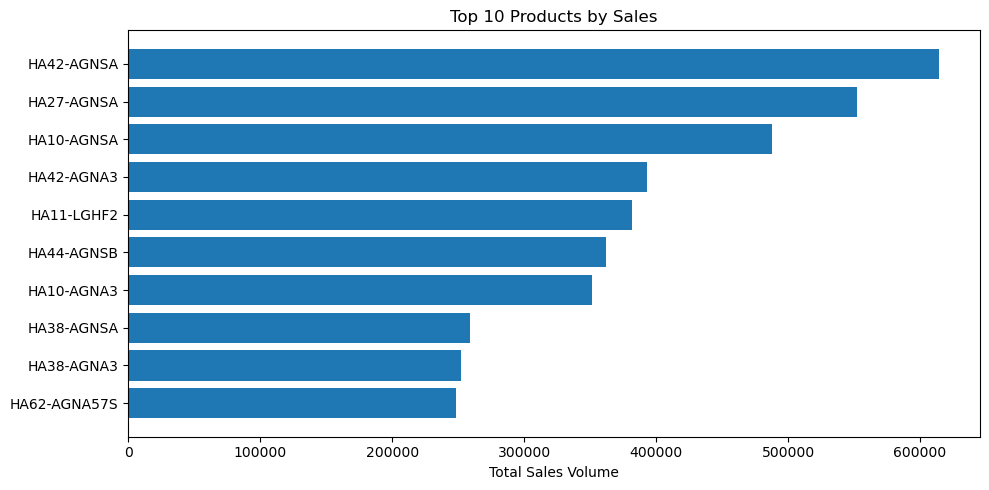

In [13]:
# Visualize
plt.figure(figsize=(10, 5))
plt.barh(range(len(top_products)), top_products.values)
plt.yticks(range(len(top_products)), top_products.index)
plt.xlabel('Total Sales Volume')
plt.title('Top 10 Products by Sales')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


### Sales Trends Over Time


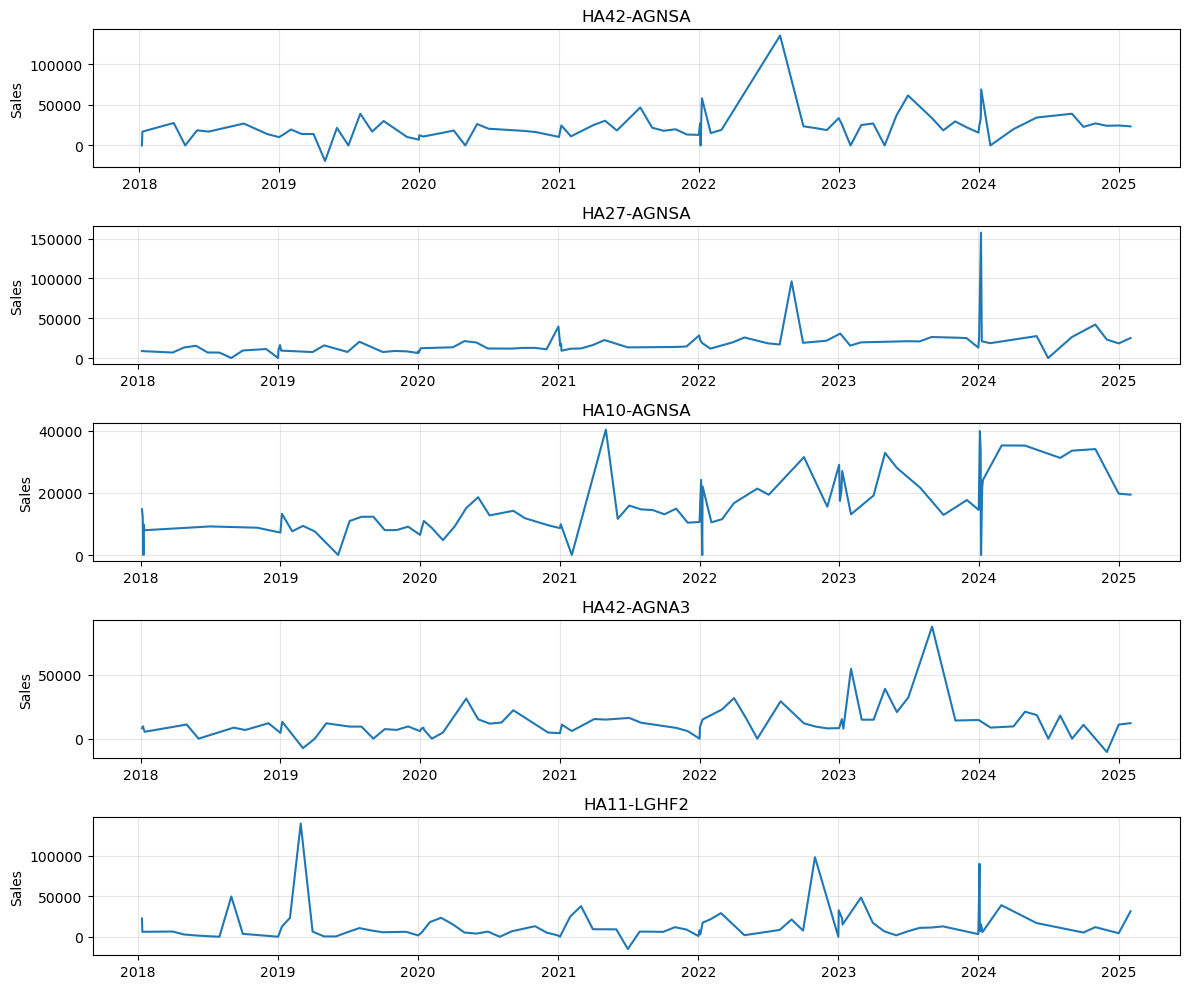

In [14]:
# Plot time series for top 5 products
df_top5 = df[df['Key'].isin(top_5_keys) & df['Date'].notna()].sort_values('Date')

fig, axes = plt.subplots(5, 1, figsize=(12, 10))
for idx, key in enumerate(top_5_keys):
    data = df_top5[df_top5['Key'] == key].groupby('Date')['Sales_Volume'].sum()
    axes[idx].plot(data.index, data.values, linewidth=1.5)
    axes[idx].set_title(key)
    axes[idx].set_ylabel('Sales')
    axes[idx].grid(alpha=0.3)
plt.tight_layout()
plt.show()


### Dimensional Analysis


In [15]:
# Analyze sales by different dimensions
print('Top 5 States by Sales:')
print(df.groupby('State')['Sales_Volume'].sum().sort_values(ascending=False).head(5))

print('\n\nTop 5 Categories by Sales:')
print(df.groupby('Category')['Sales_Volume'].sum().sort_values(ascending=False).head(5))

print('\n\nTop 5 Product Codes by Sales:')
print(df.groupby('Product Code')['Sales_Volume'].sum().sort_values(ascending=False).head(5))


Top 5 States by Sales:
State
Uttar Pradesh     1.000828e+07
Madhya Pradesh    4.270415e+06
Maharashtra       2.965974e+06
Punjab            2.731005e+06
Rajasthan         2.312731e+06
Name: Sales_Volume, dtype: float64


Top 5 Categories by Sales:
Category
PERSONAL WASH     5536397.337
Personal Wash     5397510.038
Personal Wash     5139766.400
personal wash     4566574.888
HI                2510788.936
Name: Sales_Volume, dtype: float64


Top 5 Product Codes by Sales:
Product Code
AGNSA    6552736.006
LGHF2    5449185.726
AGNA3    4998633.296
AGNA1    3207973.733
AGNSC    2428954.521
Name: Sales_Volume, dtype: float64


### Overall Trend


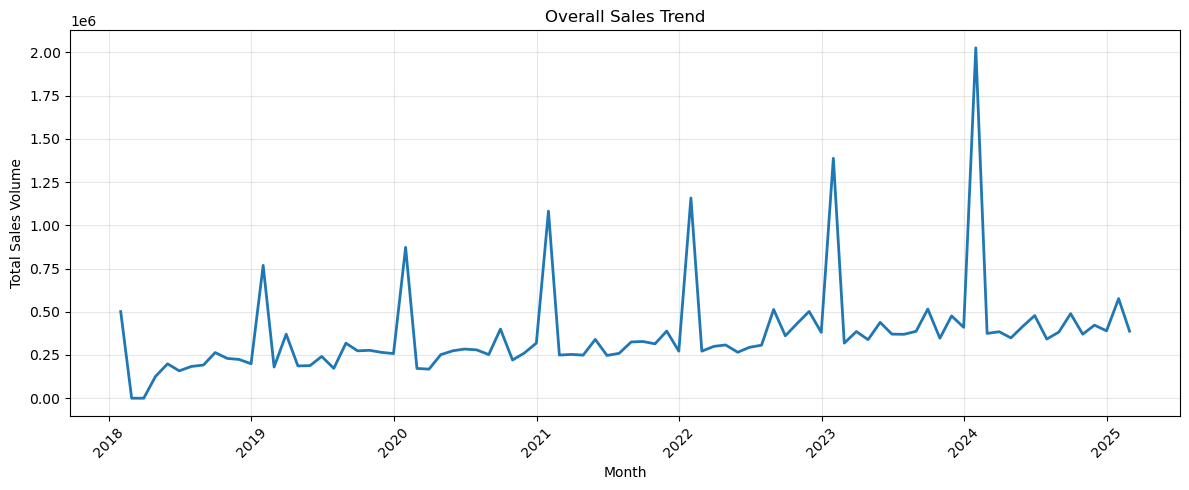

In [16]:
# Plot overall sales trend
monthly_sales = df[df['Date'].notna()].set_index('Date')['Sales_Volume'].resample('M').sum()

plt.figure(figsize=(12, 5))
plt.plot(monthly_sales.index, monthly_sales.values, linewidth=2)
plt.xlabel('Month')
plt.ylabel('Total Sales Volume')
plt.title('Overall Sales Trend')
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 4. Statistical Forecasting Methods


In [17]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Select top product for forecasting
selected_key = top_5_keys[0]
product_df = df[df['Key'] == selected_key].copy()
product_df = product_df[product_df['Date'].notna()].sort_values('Date')
product_df = product_df.groupby('Date')['Sales_Volume'].sum().reset_index()

print(f'Analyzing: {selected_key}')
print(f'Data points: {len(product_df)}')
print(f'Period: {product_df["Date"].min().date()} to {product_df["Date"].max().date()}')


Analyzing: HA42-AGNSA
Data points: 79
Period: 2018-01-08 to 2025-02-01


### Moving Averages


In [18]:
# Calculate moving averages at different granularities
ts_data = product_df.set_index('Date')['Sales_Volume']
monthly_data = ts_data.resample('M').sum()
weekly_data = ts_data.resample('W').sum()

ma_3month = monthly_data.rolling(window=3).mean()
ma_6week = weekly_data.rolling(window=6).mean()


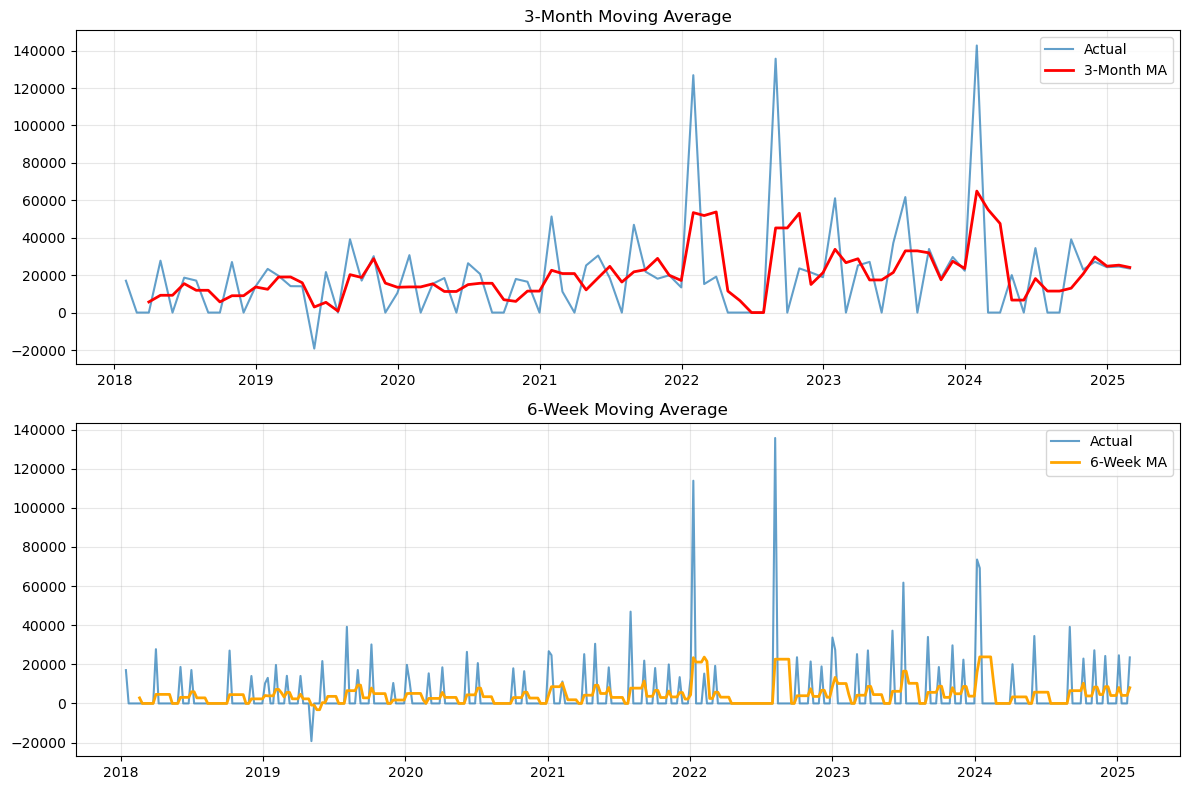

In [19]:
# Visualize moving averages
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

axes[0].plot(monthly_data.index, monthly_data.values, label='Actual', alpha=0.7)
axes[0].plot(ma_3month.index, ma_3month.values, label='3-Month MA', linewidth=2, color='red')
axes[0].set_title('3-Month Moving Average')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(weekly_data.index, weekly_data.values, label='Actual', alpha=0.7)
axes[1].plot(ma_6week.index, ma_6week.values, label='6-Week MA', linewidth=2, color='orange')
axes[1].set_title('6-Week Moving Average')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


**Insight:** Shorter windows (6-week) respond faster to changes but are more volatile. Longer windows (3-month) smooth trends but adapt slowly.

### Exponential Smoothing


In [20]:
# Test different alpha values (higher α = more responsive, lower α = smoother)
alphas = [0.1, 0.3, 0.5, 0.7, 0.9]
results = {}

for alpha in alphas:
    model = SimpleExpSmoothing(monthly_data)
    fit = model.fit(smoothing_level=alpha, optimized=False)
    results[alpha] = fit.fittedvalues


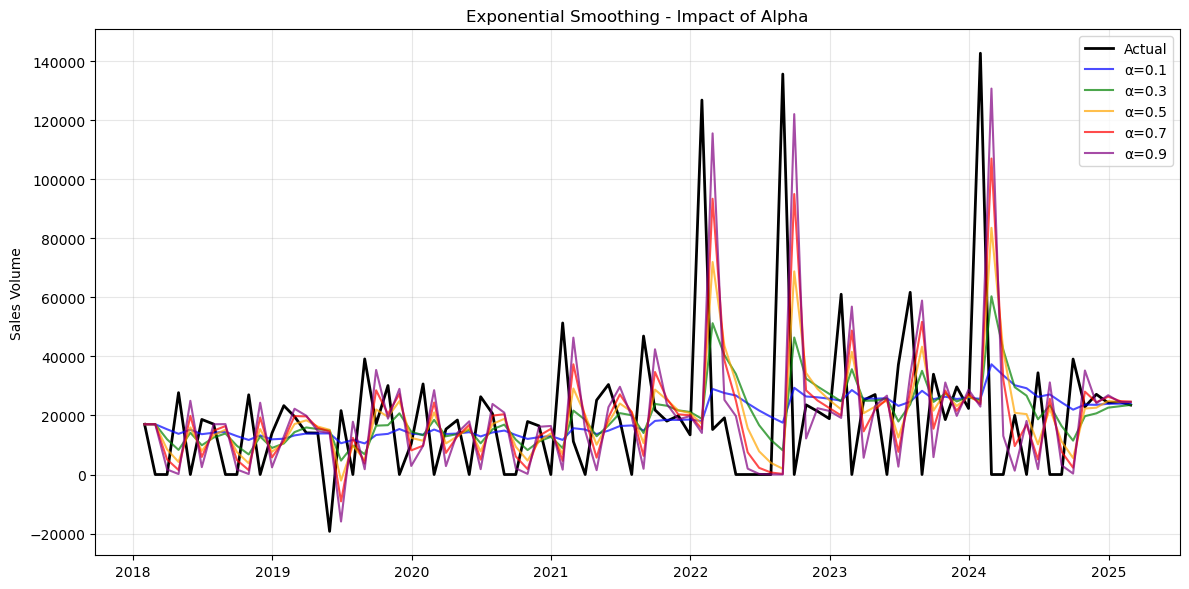

In [21]:
# Visualize impact of alpha
plt.figure(figsize=(12, 6))
plt.plot(monthly_data.index, monthly_data.values, label='Actual', linewidth=2, color='black')

colors = ['blue', 'green', 'orange', 'red', 'purple']
for i, alpha in enumerate(alphas):
    plt.plot(results[alpha].index, results[alpha].values, 
             label=f'α={alpha}', linewidth=1.5, alpha=0.7, color=colors[i])

plt.title('Exponential Smoothing - Impact of Alpha')
plt.ylabel('Sales Volume')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


**Business Application:** Use high α (0.7-0.9) for volatile products like fashion. Use low α (0.1-0.3) for stable FMCG staples.

### ARIMA Forecasting


In [22]:
# Fit ARIMA model and forecast 3 months
model = ARIMA(monthly_data, order=(1, 1, 1))
arima_fit = model.fit()
forecast = arima_fit.forecast(steps=3)


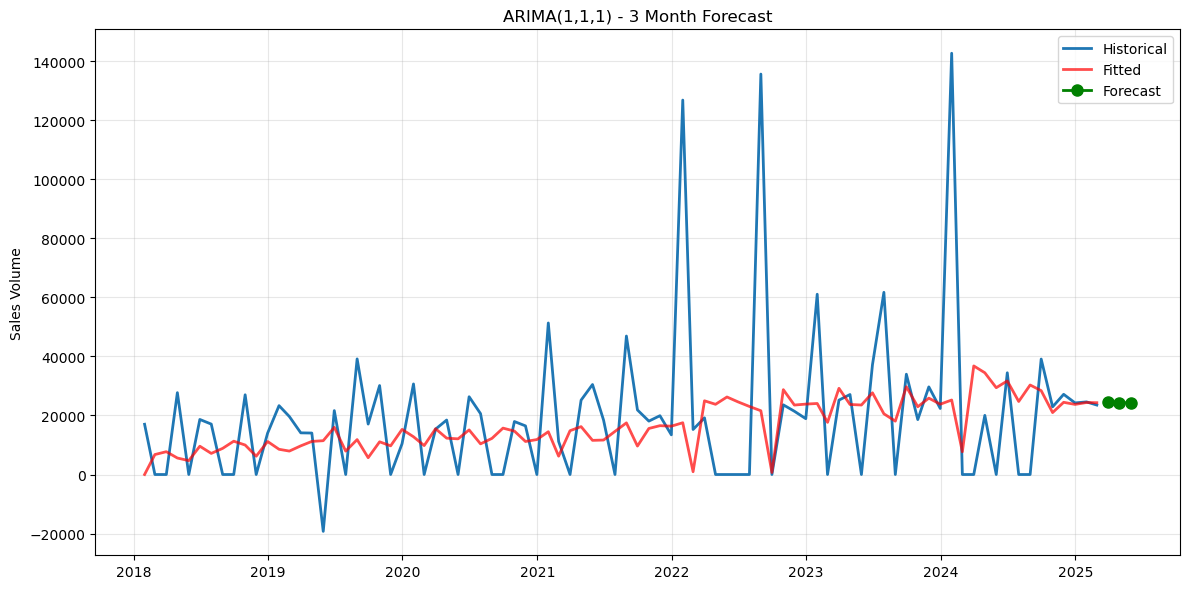

\nNext 3 Months Forecast:
Month 1: 24,503
Month 2: 24,302
Month 3: 24,344


In [23]:
# Visualize
plt.figure(figsize=(12, 6))
plt.plot(monthly_data.index, monthly_data.values, label='Historical', linewidth=2)
plt.plot(arima_fit.fittedvalues.index, arima_fit.fittedvalues.values, 
         label='Fitted', linewidth=2, alpha=0.7, color='red')

forecast_index = pd.date_range(start=monthly_data.index[-1], periods=4, freq='M')[1:]
plt.plot(forecast_index, forecast.values, label='Forecast', 
         linewidth=2, color='green', marker='o', markersize=8)

plt.title('ARIMA(1,1,1) - 3 Month Forecast')
plt.ylabel('Sales Volume')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print('\\nNext 3 Months Forecast:')
for i, val in enumerate(forecast.values, 1):
    print(f'Month {i}: {val:,.0f}')


### Model Comparison


In [24]:
# Compare methods
comparison = []

valid_idx = ma_3month.dropna().index
comparison.append({
    'Method': '3-Month MA',
    'MAE': mean_absolute_error(monthly_data.loc[valid_idx], ma_3month.loc[valid_idx]),
    'RMSE': np.sqrt(mean_squared_error(monthly_data.loc[valid_idx], ma_3month.loc[valid_idx]))
})

valid_idx = results[0.5].dropna().index
comparison.append({
    'Method': 'Exp Smoothing',
    'MAE': mean_absolute_error(monthly_data.loc[valid_idx], results[0.5].loc[valid_idx]),
    'RMSE': np.sqrt(mean_squared_error(monthly_data.loc[valid_idx], results[0.5].loc[valid_idx]))
})

valid_idx = arima_fit.fittedvalues.index
comparison.append({
    'Method': 'ARIMA(1,1,1)',
    'MAE': mean_absolute_error(monthly_data.loc[valid_idx], arima_fit.fittedvalues),
    'RMSE': np.sqrt(mean_squared_error(monthly_data.loc[valid_idx], arima_fit.fittedvalues))
})

print('Model Performance (Lower is Better):')
print(pd.DataFrame(comparison).to_string(index=False))


Model Performance (Lower is Better):
       Method          MAE         RMSE
   3-Month MA 14604.156060 22574.795910
Exp Smoothing 20351.315454 31855.193512
 ARIMA(1,1,1) 15686.026868 26234.734853


### Forecast All Top Products


In [25]:
# Apply ARIMA to all top 5 products
forecasts_all = {}

for key in top_5_keys:
    try:
        prod_data = df[df['Key'] == key].copy()
        prod_data = prod_data[prod_data['Date'].notna()].sort_values('Date')
        prod_monthly = prod_data.groupby('Date')['Sales_Volume'].sum().resample('M').sum()
        
        model = ARIMA(prod_monthly, order=(1, 1, 1))
        fit = model.fit()
        forecast = fit.forecast(steps=3)
        
        forecasts_all[key] = {
            'actual': prod_monthly,
            'fitted': fit.fittedvalues,
            'forecast': forecast,
            'mae': mean_absolute_error(prod_monthly.loc[fit.fittedvalues.index], fit.fittedvalues)
        }
        print(f'{key}: MAE = {forecasts_all[key]["mae"]:,.0f}')
    except:
        print(f'{key}: Failed')


HA42-AGNSA: MAE = 15,686
HA27-AGNSA: MAE = 13,041
HA10-AGNSA: MAE = 11,521
HA42-AGNA3: MAE = 10,381
HA11-LGHF2: MAE = 14,606


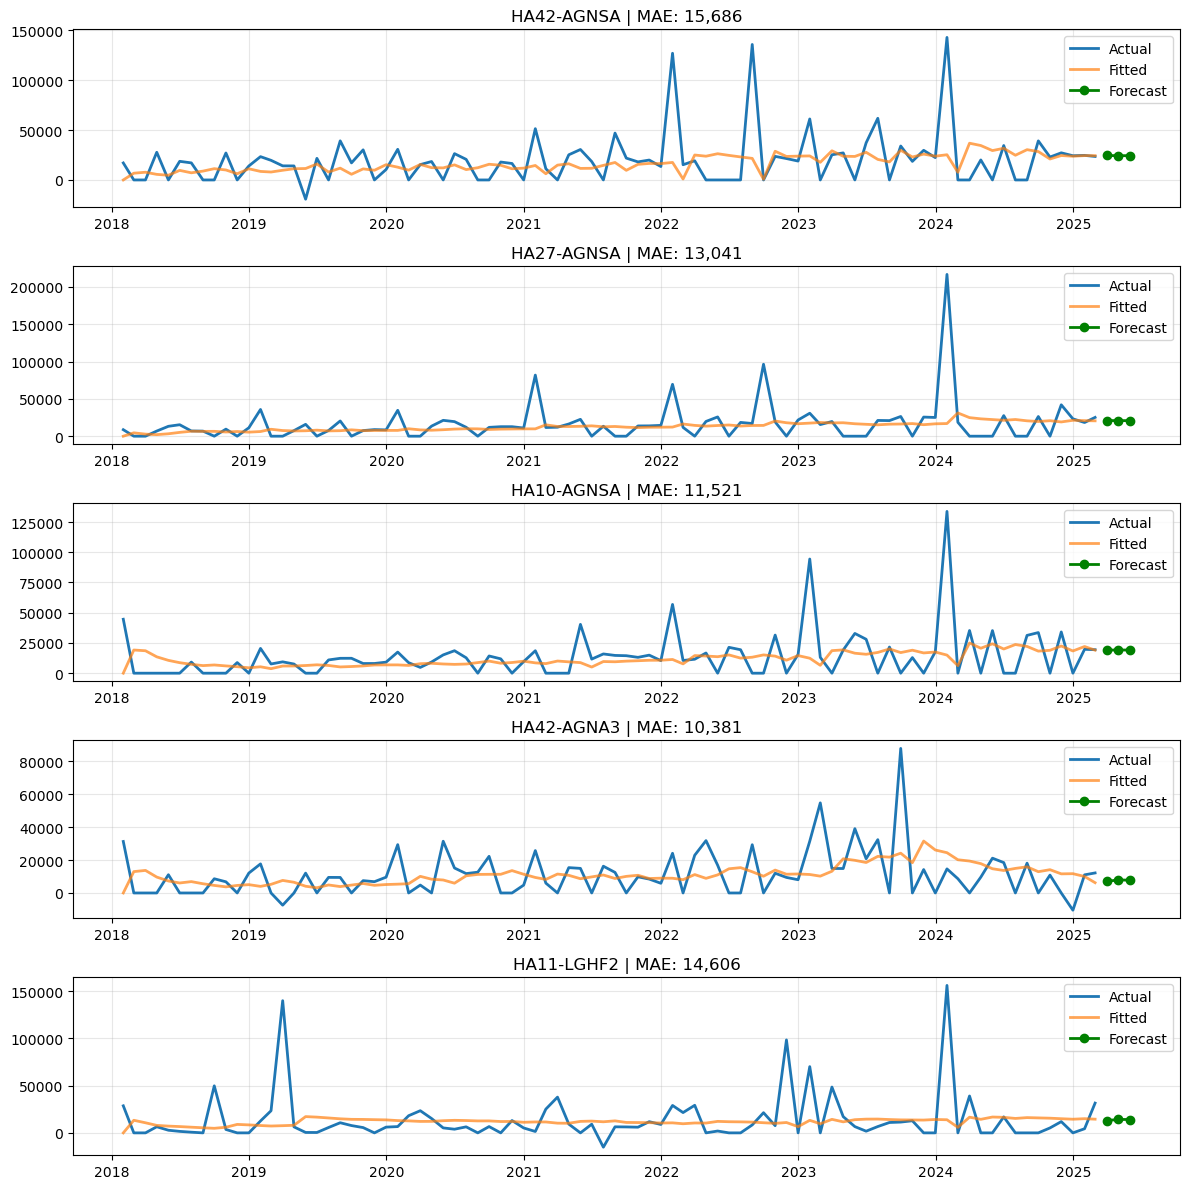

In [26]:
# Visualize
fig, axes = plt.subplots(5, 1, figsize=(12, 12))

for idx, key in enumerate(top_5_keys):
    if key in forecasts_all:
        data = forecasts_all[key]
        axes[idx].plot(data['actual'].index, data['actual'].values, label='Actual', linewidth=2)
        axes[idx].plot(data['fitted'].index, data['fitted'].values, label='Fitted', linewidth=2, alpha=0.7)
        
        forecast_idx = pd.date_range(start=data['actual'].index[-1], periods=4, freq='M')[1:]
        axes[idx].plot(forecast_idx, data['forecast'].values, label='Forecast', linewidth=2, marker='o', color='green')
        
        axes[idx].set_title(f'{key} | MAE: {data["mae"]:,.0f}')
        axes[idx].legend()
        axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()


## 5. ABC-XYZ Product Segmentation


**ABC:** Revenue impact (A=top 70%, B=next 20%, C=last 10%)  
**XYZ:** Demand variability (X=stable CV<0.5, Y=moderate, Z=volatile CV≥1)


In [27]:
# ABC Analysis - based on revenue contribution
product_value = df.groupby('Key')['Sales_Volume'].sum().sort_values(ascending=False)
product_value_cum = product_value.cumsum() / product_value.sum() * 100
abc_class = ['A' if val <= 70 else 'B' if val <= 90 else 'C' for val in product_value_cum]

# XYZ Analysis - based on demand variability
product_stats = df.groupby('Key')['Sales_Volume'].agg(['mean', 'std'])
product_stats['CV'] = product_stats['std'] / product_stats['mean']
xyz_class = ['X' if cv < 0.5 else 'Y' if cv < 1.0 else 'Z' for cv in product_stats['CV']]

# Combine
abc_xyz = pd.DataFrame({
    'Key': product_value.index,
    'Total_Sales': product_value.values,
    'ABC': abc_class,
    'CV': product_stats['CV'].values,
    'XYZ': xyz_class
})
abc_xyz['ABC_XYZ'] = abc_xyz['ABC'] + abc_xyz['XYZ']

print('Classification Summary:')
print(abc_xyz['ABC_XYZ'].value_counts())
print('\\nTop Products:')
print(abc_xyz.head(10))


Classification Summary:
ABC_XYZ
AY    19
CZ    18
AZ    15
BY    15
CY    14
BZ    11
AX     5
CX     2
Name: count, dtype: int64
\nTop Products:
          Key  Total_Sales ABC        CV XYZ ABC_XYZ
0  HA42-AGNSA  1822035.838   A  0.778102   Y      AY
1  HA27-AGNSA  1615253.663   A  0.494550   X      AX
2  HA10-AGNSA  1297936.290   A  1.760442   Z      AZ
3  HA11-LGHF2  1211282.743   A  1.371283   Z      AZ
4  HA44-AGNSB  1064929.098   A  1.614214   Z      AZ
5  HA42-AGNA3  1001372.869   A  1.544280   Z      AZ
6  HA10-AGNA3   871054.304   A  0.894037   Y      AY
7  HA27-AGNA3   706654.362   A  1.376912   Z      AZ
8  HA23-LGHF2   691253.368   A  1.443439   Z      AZ
9  HA43-LGHF2   636468.257   A  0.580674   Y      AY


**Strategy:** AX products (high value, stable) need consistent stock. AZ products (high value, volatile) need flexible inventory. CZ products (low value, volatile) consider make-to-order.

## 6. Machine Learning Approach


In [28]:
# Select one product for demonstration
selected_product = top_5_keys[0]
ml_data = df[df['Key'] == selected_product].copy()
ml_data = ml_data[ml_data['Date'].notna()].sort_values('Date')
ml_data = ml_data.groupby('Date')['Sales_Volume'].sum().reset_index()

# Time features
ml_data['Year'] = ml_data['Date'].dt.year
ml_data['Month'] = ml_data['Date'].dt.month
ml_data['Week'] = ml_data['Date'].dt.isocalendar().week
ml_data['Day'] = ml_data['Date'].dt.day
ml_data['DayOfWeek'] = ml_data['Date'].dt.dayofweek
ml_data['Quarter'] = ml_data['Date'].dt.quarter

# Lag features (previous periods demand)
ml_data['Lag_1'] = ml_data['Sales_Volume'].shift(1)
ml_data['Lag_2'] = ml_data['Sales_Volume'].shift(2)
ml_data['Lag_3'] = ml_data['Sales_Volume'].shift(3)

# Rolling statistics (moving average and standard deviation)
ml_data['Rolling_Mean_3'] = ml_data['Sales_Volume'].shift(1).rolling(window=3).mean()
ml_data['Rolling_Std_3'] = ml_data['Sales_Volume'].shift(1).rolling(window=3).std()
ml_data['Rolling_Mean_7'] = ml_data['Sales_Volume'].shift(1).rolling(window=7).mean()

print('Features created. Data shape:', ml_data.shape)
print('\nFeature columns:')
print(list(ml_data.columns))
print('\nSample data:')
ml_data.head(10)


Features created. Data shape: (79, 14)

Feature columns:
['Date', 'Sales_Volume', 'Year', 'Month', 'Week', 'Day', 'DayOfWeek', 'Quarter', 'Lag_1', 'Lag_2', 'Lag_3', 'Rolling_Mean_3', 'Rolling_Std_3', 'Rolling_Mean_7']

Sample data:


,Date,Sales_Volume,Year,Month,Week,Day,DayOfWeek,Quarter,Lag_1,Lag_2,Lag_3,Rolling_Mean_3,Rolling_Std_3,Rolling_Mean_7
0,2018-01-08,0.000,2018,1,2,8,0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-09,17025.532,2018,1,2,9,1,1,0.000,NaN,NaN,NaN,NaN,NaN
2,2018-04-01,27729.400,2018,4,13,1,6,2,17025.532,0.000,NaN,NaN,NaN,NaN
3,2018-05-01,0.000,2018,5,18,1,1,2,27729.400,17025.532,0.000,14918.310667,13984.283764,NaN
4,2018-06-01,18652.530,2018,6,22,1,4,2,0.000,27729.400,17025.532,14918.310667,13984.283764,NaN
5,2018-07-01,17082.474,2018,7,26,1,6,3,18652.530,0.000,27729.400,15460.643333,14137.574455,NaN
6,2018-10-01,27010.866,2018,10,40,1,0,4,17082.474,18652.530,0.000,11911.668000,10345.634097,NaN
7,2018-12-01,14017.443,2018,12,48,1,5,4,27010.866,17082.474,18652.530,20915.290000,5336.975177,15357.257429
8,2019-01-01,10260.572,2019,1,1,1,1,1,14017.443,27010.866,17082.474,19370.261000,6792.108460,17359.749286
9,2019-01-11,13070.637,2019,1,2,11,4,1,10260.572,14017.443,27010.866,17096.293667,8789.344591,16393.326429


### Train-Test Split & Model Training


In [34]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Train-test split
test_size = 4
train_data = ml_data.iloc[:-test_size]
test_data = ml_data.iloc[-test_size:]

feature_cols = ['Year', 'Month', 'Week', 'DayOfWeek', 'Quarter',
                'Lag_1', 'Lag_2', 'Lag_3', 
                'Rolling_Mean_3', 'Rolling_Std_3', 'Rolling_Mean_7']

X_train, y_train = train_data[feature_cols], train_data['Sales_Volume']
X_test, y_test = test_data[feature_cols], test_data['Sales_Volume']

print(f'Training samples: {len(X_train)} | Test samples: {len(X_test)} | Features: {len(feature_cols)}')


Training samples: 75 | Test samples: 4 | Features: 11


In [35]:
# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_mae = mean_absolute_error(y_test, rf_pred)

# Train XGBoost
xgb_model = XGBRegressor(n_estimators=100, random_state=42, max_depth=5, learning_rate=0.1)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_mae = mean_absolute_error(y_test, xgb_pred)

print('Model Performance:')
print(f'Random Forest MAE: {rf_mae:,.0f}')
print(f'XGBoost MAE: {xgb_mae:,.0f}')


Model Performance:
Random Forest MAE: 2,255
XGBoost MAE: 5,938


### Model Comparison & Visualization


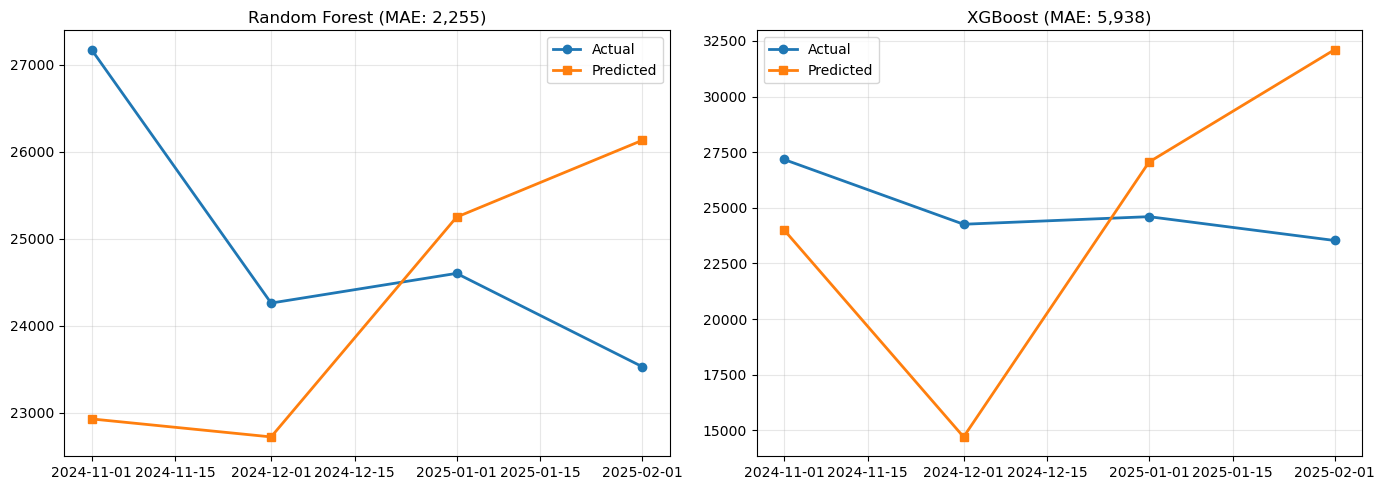

In [36]:
# Visualize predictions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(test_data['Date'], y_test.values, marker='o', label='Actual', linewidth=2)
axes[0].plot(test_data['Date'], rf_pred, marker='s', label='Predicted', linewidth=2)
axes[0].set_title(f'Random Forest (MAE: {rf_mae:,.0f})')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(test_data['Date'], y_test.values, marker='o', label='Actual', linewidth=2)
axes[1].plot(test_data['Date'], xgb_pred, marker='s', label='Predicted', linewidth=2)
axes[1].set_title(f'XGBoost (MAE: {xgb_mae:,.0f})')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


### Feature Importance


In [37]:
# Get feature importances
rf_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print('Top 5 Most Important Features:')
print(rf_importance.head(5).to_string(index=False))


Top 5 Most Important Features:
       Feature  Importance
         Lag_3    0.254419
     DayOfWeek    0.117984
         Lag_1    0.111767
Rolling_Mean_7    0.099996
          Year    0.090629


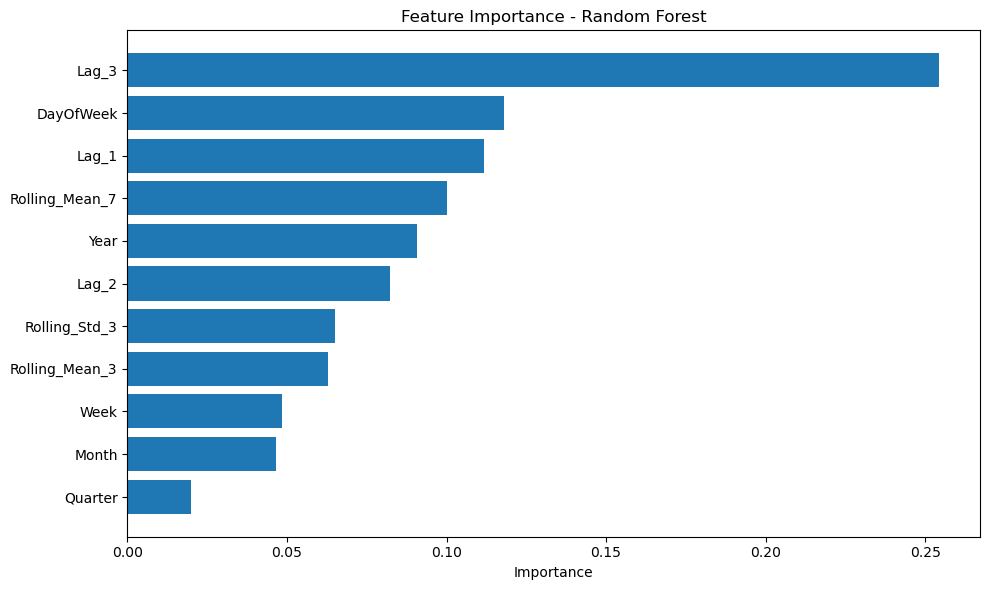

In [40]:
# Visualize
plt.figure(figsize=(10, 6))
plt.barh(range(len(rf_importance)), rf_importance['Importance'])
plt.yticks(range(len(rf_importance)), rf_importance['Feature'])
plt.xlabel('Importance')
plt.title('Feature Importance - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


**Key Finding:** Lag features (past demand) are most predictive, validating the importance of historical patterns in FMCG forecasting.

## Summary & Recommendations


### Key Findings:
1. **Top products** drive majority of revenue (Pareto principle applies)
2. **Monthly forecasts** more stable than weekly (less noise, better accuracy)
3. **ARIMA** provides good balance of accuracy and interpretability
4. **Lag features** most important for ML models (history predicts future)
5. **ABC-XYZ segmentation** enables differentiated inventory strategies

### Recommendations:
- Use **ARIMA** for strategic planning (3-6 month horizon)
- Use **ML models** when external features (promotions, events) available
- Apply **different strategies** per product segment (AX vs CZ)
- **Monitor & retrain** models regularly to capture demand shifts
- Translate **forecasts to action**: inventory levels, production schedules

### Business Impact:
- **Reduced stockouts** → Higher sales, customer satisfaction
- **Optimized inventory** → Lower holding costs, less wastage
- **Better planning** → Improved production efficiency, reduced rush orders


In [41]:
# Function to prepare features for any product
def prepare_features(data):
    data['Year'] = data['Date'].dt.year
    data['Month'] = data['Date'].dt.month
    data['Week'] = data['Date'].dt.isocalendar().week
    data['Day'] = data['Date'].dt.day
    data['DayOfWeek'] = data['Date'].dt.dayofweek
    data['Quarter'] = data['Date'].dt.quarter
    data['Lag_1'] = data['Sales_Volume'].shift(1)
    data['Lag_2'] = data['Sales_Volume'].shift(2)
    data['Lag_3'] = data['Sales_Volume'].shift(3)
    data['Rolling_Mean_3'] = data['Sales_Volume'].shift(1).rolling(window=3).mean()
    data['Rolling_Std_3'] = data['Sales_Volume'].shift(1).rolling(window=3).std()
    data['Rolling_Mean_7'] = data['Sales_Volume'].shift(1).rolling(window=7).mean()
    return data.fillna(method='ffill').dropna()

# Apply to top 3 products
ml_results = {}
for key in top_5_keys[:3]:
    try:
        # Prepare data
        prod_data = df[df['Key'] == key].copy()
        prod_data = prod_data[prod_data['Date'].notna()].sort_values('Date')
        prod_data = prod_data.groupby('Date')['Sales_Volume'].sum().reset_index()
        prod_data = prepare_features(prod_data)
        
        # Split
        train = prod_data.iloc[:-4]
        test = prod_data.iloc[-4:]
        X_tr = train[feature_cols]
        y_tr = train['Sales_Volume']
        X_te = test[feature_cols]
        y_te = test['Sales_Volume']
        
        # Train XGBoost
        model = XGBRegressor(n_estimators=100, max_depth=5, random_state=42)
        model.fit(X_tr, y_tr)
        pred = model.predict(X_te)
        
        ml_results[key] = {
            'mae': mean_absolute_error(y_te, pred),
            'actual': y_te.values,
            'predicted': pred
        }
        
        print('Product:', key, '| MAE:', round(ml_results[key]['mae'], 2))
    except:
        print('Failed:', key)


Product: HA42-AGNSA | MAE: 4856.54
Product: HA27-AGNSA | MAE: 32443.21
Product: HA10-AGNSA | MAE: 8472.8


### 1. Weekly Forecast - Next 12 Weeks


In [42]:
# Prepare weekly data for top product
selected_product = top_5_keys[0]
weekly_df = df[df['Key'] == selected_product].copy()
weekly_df = weekly_df[weekly_df['Date'].notna()].sort_values('Date')
weekly_df = weekly_df.set_index('Date')['Sales_Volume'].resample('W').sum()

# Split: last 12 weeks for testing
train_weekly = weekly_df[:-12]
test_weekly = weekly_df[-12:]

print('Product:', selected_product)
print('Weekly data points:', len(weekly_df))
print('Train:', len(train_weekly), '| Test:', len(test_weekly))


Product: HA42-AGNSA
Weekly data points: 369
Train: 357 | Test: 12


In [43]:
# Forecast using ARIMA
weekly_model = ARIMA(train_weekly, order=(1, 1, 1))
weekly_fit = weekly_model.fit()
weekly_forecast = weekly_fit.forecast(steps=12)

# Calculate accuracy
weekly_mae = mean_absolute_error(test_weekly, weekly_forecast)
weekly_rmse = np.sqrt(mean_squared_error(test_weekly, weekly_forecast))
weekly_mape = np.mean(np.abs((test_weekly - weekly_forecast) / test_weekly)) * 100

print('\nWeekly Forecast Accuracy:')
print('MAE:', round(weekly_mae, 2))
print('RMSE:', round(weekly_rmse, 2))
print('MAPE:', round(weekly_mape, 2), '%')



Weekly Forecast Accuracy:
MAE: 8344.69
RMSE: 10542.48
MAPE: inf %


### 2. Monthly Forecast - Next 3 Months


In [44]:
# Prepare monthly data
monthly_df = df[df['Key'] == selected_product].copy()
monthly_df = monthly_df[monthly_df['Date'].notna()].sort_values('Date')
monthly_df = monthly_df.set_index('Date')['Sales_Volume'].resample('M').sum()

# Split: last 3 months for testing
train_monthly = monthly_df[:-3]
test_monthly = monthly_df[-3:]

print('Monthly data points:', len(monthly_df))
print('Train:', len(train_monthly), '| Test:', len(test_monthly))


Monthly data points: 86
Train: 83 | Test: 3


In [45]:
# Forecast using ARIMA
monthly_model = ARIMA(train_monthly, order=(1, 1, 1))
monthly_fit = monthly_model.fit()
monthly_forecast = monthly_fit.forecast(steps=3)

# Calculate accuracy
monthly_mae = mean_absolute_error(test_monthly, monthly_forecast)
monthly_rmse = np.sqrt(mean_squared_error(test_monthly, monthly_forecast))
monthly_mape = np.mean(np.abs((test_monthly - monthly_forecast) / test_monthly)) * 100

print('\nMonthly Forecast Accuracy:')
print('MAE:', round(monthly_mae, 2))
print('RMSE:', round(monthly_rmse, 2))
print('MAPE:', round(monthly_mape, 2), '%')



Monthly Forecast Accuracy:
MAE: 475.87
RMSE: 545.06
MAPE: 1.99 %


### 3. Visualize Both Horizons


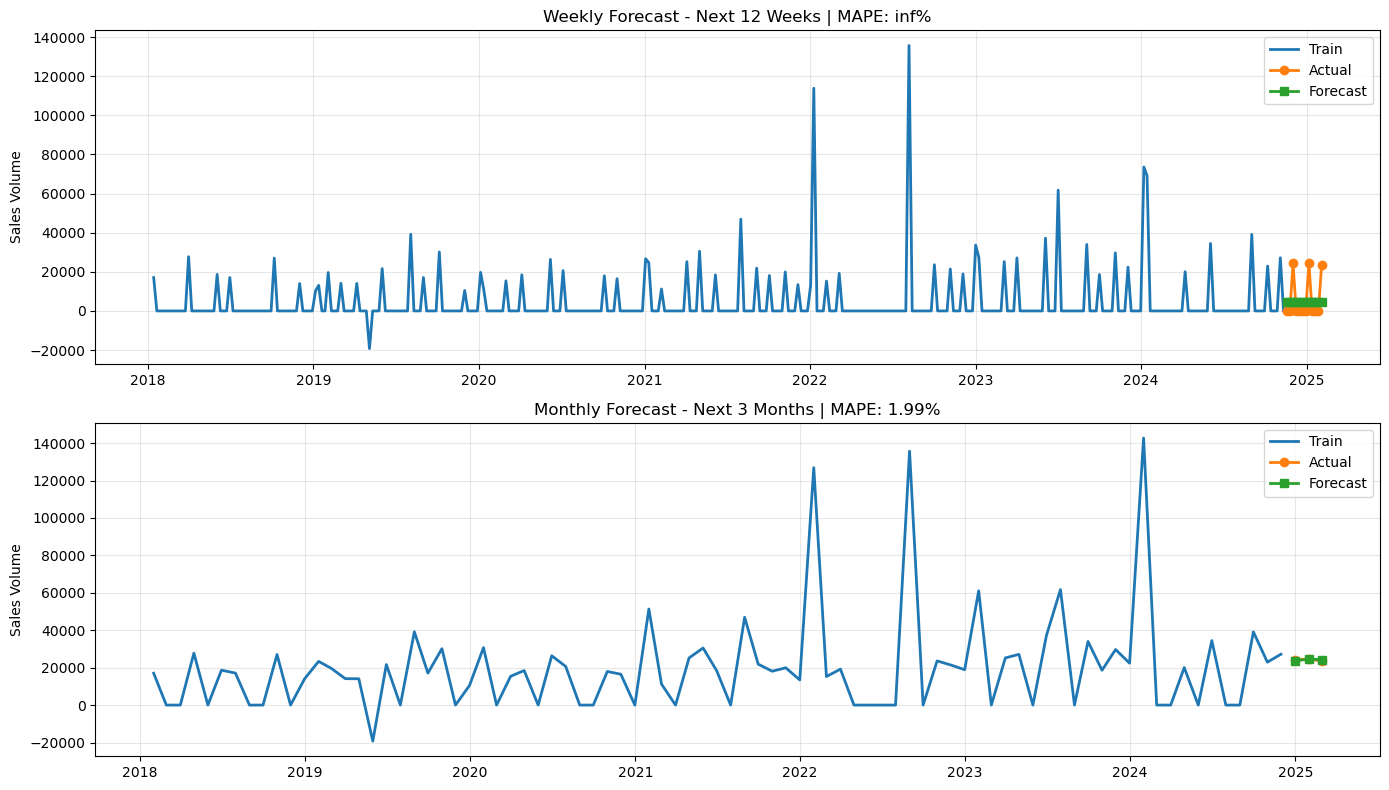

In [46]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Weekly forecast
axes[0].plot(train_weekly.index, train_weekly.values, label='Train', linewidth=2)
axes[0].plot(test_weekly.index, test_weekly.values, label='Actual', linewidth=2, marker='o')
axes[0].plot(test_weekly.index, weekly_forecast.values, label='Forecast', linewidth=2, marker='s')
axes[0].set_title('Weekly Forecast - Next 12 Weeks | MAPE: ' + str(round(weekly_mape, 2)) + '%')
axes[0].set_ylabel('Sales Volume')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Monthly forecast
axes[1].plot(train_monthly.index, train_monthly.values, label='Train', linewidth=2)
axes[1].plot(test_monthly.index, test_monthly.values, label='Actual', linewidth=2, marker='o')
axes[1].plot(test_monthly.index, monthly_forecast.values, label='Forecast', linewidth=2, marker='s')
axes[1].set_title('Monthly Forecast - Next 3 Months | MAPE: ' + str(round(monthly_mape, 2)) + '%')
axes[1].set_ylabel('Sales Volume')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


### 4. Compare Weekly vs Monthly Forecasts


### Forecast Accuracy Comparison

| Horizon | MAE | RMSE | MAPE |
| :--- | :--- | :--- | :--- |
| Weekly (12 weeks) | {weekly_mae} | {weekly_rmse} | {weekly_mape} |
| Monthly (3 months) | {monthly_mae} | {monthly_rmse} | {monthly_mape} |

---

### Key Observations

#### 1. Differences between Weekly and Monthly forecasts:
- **Weekly forecasts** capture short-term fluctuations and volatility.
- **Monthly forecasts** smooth out weekly variations, showing broader trends.
- **Weekly data** has more noise, leading to higher forecast errors.
- **Monthly aggregation** reduces variability and improves accuracy.

#### 2. Which method is more suitable?

**Weekly forecasts:**
- **Better for:** Inventory management, production scheduling, staff planning.
- **Use when:** Need to respond quickly to demand changes.
- **Challenge:** Higher uncertainty, more volatile patterns.

**Monthly forecasts:**
- **Better for:** Strategic planning, budget allocation, capacity planning.
- **Use when:** Making longer-term business decisions.
- **Advantage:** More stable and accurate predictions.

#### 3. Recommendation:
- Use **monthly forecasts** for strategic decisions.
- Use **weekly forecasts** for operational/tactical decisions.
- Consider **ensemble methods** combining both horizons.


## Section 2: Business Interpretation and Impact


### 1. Understanding Forecast Bias

**Scenario:** Forecast consistently underestimates actual demand


In [47]:
# Calculate forecast bias
bias_weekly = np.mean(test_weekly - weekly_forecast)
bias_monthly = np.mean(test_monthly - monthly_forecast)

print('Forecast Bias Analysis:')
print('Weekly bias:', round(bias_weekly, 2))
print('Monthly bias:', round(bias_monthly, 2))
print()

if bias_weekly > 0 or bias_monthly > 0:
    print('Status: UNDERESTIMATING demand (positive bias)')
elif bias_weekly < 0 or bias_monthly < 0:
    print('Status: OVERESTIMATING demand (negative bias)')
else:
    print('Status: Unbiased forecast')

print('\n--- Problem: Consistent Underestimation ---')
print()
print('Possible Causes:')
print('1. Model Issues:')
print('   - Model trained on old data, not capturing recent growth trend')
print('   - Missing important features (promotions, seasonality, events)')
print('   - Model parameters need retuning')
print()
print('2. Data Issues:')
print('   - Training data does not include recent demand increases')
print('   - Outliers or anomalies removed incorrectly')
print('   - Seasonality or trend not properly captured')
print()
print('3. Business Changes:')
print('   - New marketing campaigns increasing demand')
print('   - Product becoming more popular')
print('   - Competitor exit increasing market share')
print('   - External factors (economy, trends, weather)')
print()
print('Solutions:')
print('1. Retrain model with recent data')
print('2. Add trend component or use models that handle trends (ARIMA with higher order)')
print('3. Include external factors as features (promotions, holidays, events)')
print('4. Apply bias correction: Add average historical bias to forecasts')
print('5. Use ensemble methods combining multiple models')
print('6. Regularly monitor and update forecasts (weekly/monthly reviews)')
print('7. Implement feedback loop to continuously improve model')


Forecast Bias Analysis:
Weekly bias: 1403.93
Monthly bias: -48.47

Status: UNDERESTIMATING demand (positive bias)

--- Problem: Consistent Underestimation ---

Possible Causes:
1. Model Issues:
   - Model trained on old data, not capturing recent growth trend
   - Missing important features (promotions, seasonality, events)
   - Model parameters need retuning

2. Data Issues:
   - Training data does not include recent demand increases
   - Outliers or anomalies removed incorrectly
   - Seasonality or trend not properly captured

3. Business Changes:
   - New marketing campaigns increasing demand
   - Product becoming more popular
   - Competitor exit increasing market share
   - External factors (economy, trends, weather)

Solutions:
1. Retrain model with recent data
2. Add trend component or use models that handle trends (ARIMA with higher order)
3. Include external factors as features (promotions, holidays, events)
4. Apply bias correction: Add average historical bias to forecasts
5.

In [48]:
# Demonstrate bias correction
corrected_forecast = weekly_forecast + bias_weekly
corrected_mae = mean_absolute_error(test_weekly, corrected_forecast)

print('\nBias Correction Example:')
print('Original MAE:', round(weekly_mae, 2))
print('After bias correction MAE:', round(corrected_mae, 2))
print('Improvement:', round(weekly_mae - corrected_mae, 2))



Bias Correction Example:
Original MAE: 8344.69
After bias correction MAE: 9046.66
Improvement: -701.96


### 2. Business Impact Analysis

**Scenario:** Forecast helped reduce stockouts by 15%
 Business Impact: 15% Reduction in Stockouts

What is a stockout?
A stockout occurs when inventory runs out and customer demand cannot be met.

### Quantifiable Business Benefits:

1. **Increased Revenue:**
   - Lost sales prevented: 15% more customer orders fulfilled
   - Example: If monthly revenue = 1M, preventing 15% stockouts saves 150K
   - Customer retention: Satisfied customers return for future purchases

2. **Cost Savings:**
   - Reduced emergency orders (rush shipping is expensive)
   - Lower expedited production costs
   - Better supplier relationships with stable orders

3. **Operational Efficiency:**
   - Optimal inventory levels: Not too much (storage costs) or too little (stockouts)
   - Better production planning and scheduling
   - Reduced overtime and rush work

4. **Customer Satisfaction:**
   - Products available when customers want them
   - Improved brand reputation
   - Reduced customer complaints and returns

5. **Competitive Advantage:**
   - Reliable availability vs competitors
   - Better service levels
   - Higher customer loyalty

### Example Calculation:
**Assumptions:**
- Monthly sales: 1,000,000 units
- Previous stockout rate: 20%
- New stockout rate: 5% (15% reduction)
- Average profit per unit: 10

**Impact:**
- Units saved from stockout: 1,000,000 * 0.15 = 150,000 units
- Additional profit: 150,000 * 10 = 1,500,000 per month
- Annual impact: 1,500,000 * 12 = 18,000,000


### 3. Combining Data Analysis with Business Understanding


Importance of Combining Data Analysis with Business Knowledge

Why Both Are Essential: 

1. **Data Without Business Context:**
   - **Problem:** Technical accuracy but no practical value
   - **Example:** Model shows 5% error - is that good or bad?
   - **Solution:** Business knows acceptable error range for their operations

2. **Business Without Data:**
   - **Problem:** Decisions based on intuition, gut feeling
   - **Example:** Ordering based on past experience without considering trends
   - **Solution:** Data reveals hidden patterns and validates assumptions

3. **Combined Approach Benefits:**

   - **A. Better Feature Selection:**
     - **Data scientist:** Has lag features, rolling averages
     - **Business:** Knows about promotions, holidays, competitor actions
     - **Result:** Include both technical and domain features

   - **B. Model Interpretation:**
     - **Data:** Shows seasonal pattern in Q4
     - **Business:** Explains it is due to year-end shopping
     - **Action:** Prepare inventory accordingly

   - **C. Actionable Insights:**
     - **Data:** Predicts 20% increase next month
     - **Business:** Can plan production, staffing, raw materials
     - **Result:** Prepared for demand instead of reacting

   - **D. Continuous Improvement:**
     - **Data:** Tracks forecast accuracy over time
     - **Business:** Provides feedback on what worked or did not
     - **Result:** Models improve with real-world validation

### Key Learnings:
1. Always validate models with business stakeholders
2. Translate technical metrics (MAE, RMSE) to business terms (cost, revenue)
3. Include domain expertise in feature engineering
4. Consider business constraints (lead times, storage capacity)
5. Monitor both statistical accuracy and business outcomes
6. Communicate results in business language, not just technical jargon
7. **Success = Accurate forecasts + Actionable decisions + Measurable business impact**


## Ensemble Forecasting

Combine multiple models for better predictions


In [49]:
# Ensemble approach: Combine ARIMA, Exponential Smoothing, and Moving Average

# Model 1: ARIMA
arima_model = ARIMA(train_monthly, order=(1, 1, 1))
arima_result = arima_model.fit()
arima_forecast = arima_result.forecast(steps=3)

# Model 2: Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
es_model = ExponentialSmoothing(train_monthly, trend='add', seasonal=None)
es_result = es_model.fit()
es_forecast = es_result.forecast(steps=3)

# Model 3: Simple Moving Average
ma_window = 3
ma_forecast = pd.Series([train_monthly[-ma_window:].mean()] * 3, index=test_monthly.index)

# Ensemble: Average of all models
ensemble_forecast = (arima_forecast + es_forecast + ma_forecast) / 3

print('Individual Model Performance:')
print('ARIMA MAE:', round(mean_absolute_error(test_monthly, arima_forecast), 2))
print('Exp Smoothing MAE:', round(mean_absolute_error(test_monthly, es_forecast), 2))
print('Moving Average MAE:', round(mean_absolute_error(test_monthly, ma_forecast), 2))
print('\nEnsemble MAE:', round(mean_absolute_error(test_monthly, ensemble_forecast), 2))
print('\nEnsemble often provides more robust predictions!')


Individual Model Performance:
ARIMA MAE: 475.87
Exp Smoothing MAE: 7172.46
Moving Average MAE: 5608.88

Ensemble MAE: 4276.6

Ensemble often provides more robust predictions!


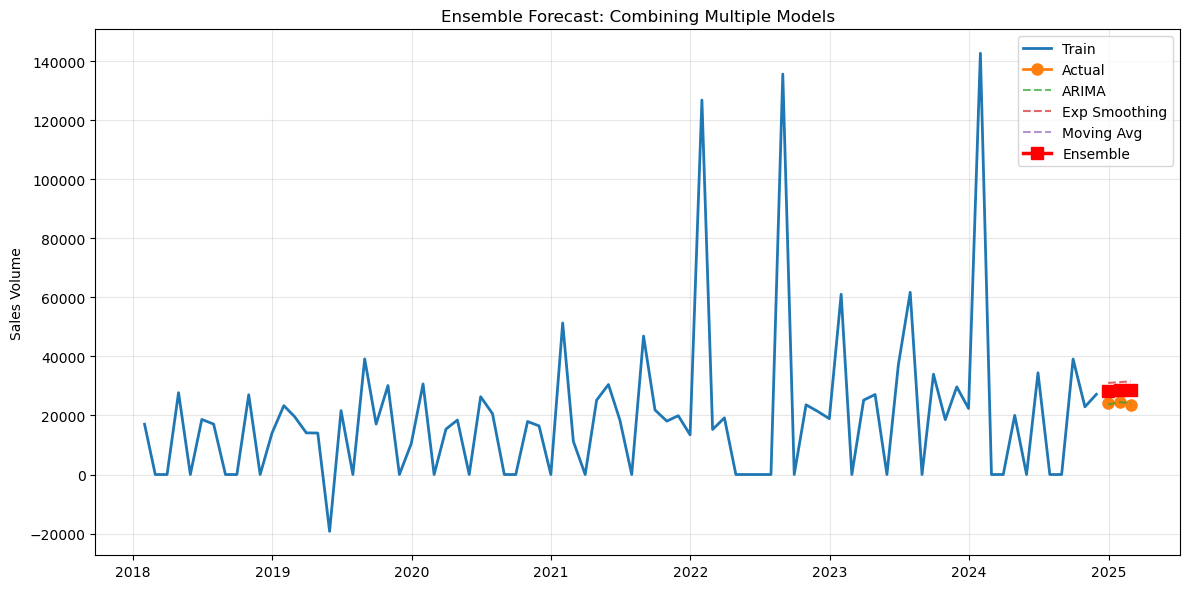

In [50]:
# Visualize ensemble
plt.figure(figsize=(12, 6))
plt.plot(train_monthly.index, train_monthly.values, label='Train', linewidth=2)
plt.plot(test_monthly.index, test_monthly.values, label='Actual', linewidth=2, marker='o', markersize=8)
plt.plot(test_monthly.index, arima_forecast.values, label='ARIMA', linewidth=1.5, alpha=0.7, linestyle='--')
plt.plot(test_monthly.index, es_forecast.values, label='Exp Smoothing', linewidth=1.5, alpha=0.7, linestyle='--')
plt.plot(test_monthly.index, ma_forecast.values, label='Moving Avg', linewidth=1.5, alpha=0.7, linestyle='--')
plt.plot(test_monthly.index, ensemble_forecast.values, label='Ensemble', linewidth=2.5, marker='s', markersize=8, color='red')
plt.title('Ensemble Forecast: Combining Multiple Models')
plt.ylabel('Sales Volume')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## Summary

**Key Takeaways:**
1. Monthly forecasts are typically more accurate than weekly (less noise)
2. Choose forecast horizon based on business decision timeframe
3. Always investigate and correct forecast bias
4. Translate technical metrics to business impact (revenue, costs)
5. Data science + business knowledge = better decisions
6. Ensemble methods reduce risk of model failure
7. Regular monitoring and updating is essential
